# Movie Review Sentiments by Matthew Inglis-Whalen [2023]

A common use-case for Natural Language Processing is to determine the sentiment of a text submission. In this notebook we train a bag-of-words model to predict whether or not a given movie review is positive or negative. For example, words like "bad" and "worst" in a review are correlated with a low rating for the movie, while words like "great" and "excellent" are correlated with a good rating. The model uses 1- and 2-gram token sizes, but is still easily fooled. A short and simple review like "Not great." will result in a positive sentiment prediction with a 99.2% prediction probability. Nevertheless, among the reviews in the withheld test set, this simple bag-of-words model achieves an accuracy of 91%.

In [6]:
USE_PREMADE = False

# standard imports
import numpy as np
import pandas as pd

# utility
from time import perf_counter

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving model
import pickle as pkl

from scipy.sparse._csr import csr_matrix

from asizeof import asizeof as better_sizeof  # check vectorizer and model are small enough (<100MB) for AWS micro (500-700MB memory)


## Cleaning

Let's import and examine the first few rows of data

In [2]:
data_path = "../data/IMDB_Dataset.csv"

reviews_raw = pd.read_csv(data_path)
reviews_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
def sentiment_to_int(s : str) -> int:
    if s == "positive" :
        return 1
    return 0

reviews = reviews_raw['review']
ratings = reviews_raw['sentiment'].map(sentiment_to_int)

print(reviews[3])
print(ratings[3])

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.
0


In [4]:
def decode_document_bag(sp_arr : csr_matrix) -> (str, int) :
    mylist = [(ordered_keys[j],sp_arr[i,j]) for i, j in zip(*sp_arr.nonzero())]
    return mylist

def sort_decoded(dec: (str,int)) -> (str, int) :
    sorted_bag = sorted(dec, key = lambda x: x[1], reverse=True)
    return sorted_bag

def print_document_bag(sp_arr : csr_matrix) :
    mylist = decode_document_bag(sp_arr)
    print(mylist)

def sorted_decoded_bag(sp_arr : csr_matrix) -> (str, int) :
    decoded = decode_document_bag(sp_arr)
    sorted_bag = sort_decoded(decoded)
    return sorted_bag

## Model genesis

We use a TfidfVectorizer. This is a CountVectorizer (the bag-of-words) to condense a document down to a dictionary of word occurences, followed by a TfidfTransformer (Term Frequency * Inverse Document Frequency) to normalize the dictionary so that document length has no influence on predictions.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_to_exclude = ["br","the","a","is","of","and","it","to","would","your","which","so","this",
                     "was","ll","on","or","for","with","as","me","that","in","be","but","could",
                     "its","em","has","then","were","where","who","thats"]
# tokens_to_exclude = ["br","the","a","and"]
# vectorizer =  CountVectorizer(ngram_range=(1,2), stop_words = tokens_to_exclude, min_df=10, strip_accents='ascii' ).fit(reviews)
# for AWS micro the vocabulary needs to be small , so we choose a fairly large cutoff for the vectorizer
vectorizer = TfidfVectorizer( ngram_range=(1,2), stop_words = tokens_to_exclude, min_df = 100, strip_accents='ascii', norm='l2' )
vectorizer.fit(reviews)

vocab = vectorizer.vocabulary_
ordered_keys = vectorizer.get_feature_names_out()
print(f"Created a vocabulary of length {len(vocab)}")

first50 = []
for idx, word in enumerate(ordered_keys) :
    if idx == 50 :
        break
    first50.append(word)
print(f"{better_sizeof(vectorizer)/1e6:.1f}MB")


Created a vocabulary of length 11248
509.4MB


SystemExit: 

c:\users\matt\documents\github\moviereviewsentiments\venv\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

transformed_X = vectorizer.transform(reviews)

X_train, X_test, y_train, y_test = train_test_split(transformed_X, ratings, test_size=0.2, random_state=2023)

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=5000)

logreg_grid = {
    'penalty' : ['l2'],
    'C' : [5, 10, 20]
}
logreg_grid_quick = {
    'penalty': ['l2'],
    'C': [10]
}

In [8]:
# runtime is 352 seconds on my machine
t0 = perf_counter()

if USE_PREMADE :
    with open('sentiment_inference_model.pkl', 'rb') as f_m :
        best_model = pkl.load(f_m)
else :
    search_cv = GridSearchCV(estimator=logreg, 
                             param_grid=logreg_grid_quick,
                             scoring='accuracy',
                             cv=5)
    search_cv.fit(X_train,y_train)
    
    best_model = search_cv.best_estimator_
    best_hypers = search_cv.best_params_
    avg_score = search_cv.best_score_
    
    print(f"Best logistic regression model achieves an average accuracy of {avg_score:.2F} with args {best_hypers}")
t1 = perf_counter()
print(f"Ran in {t1-t0:.1f} seconds")

Best logistic regression model achieves an average accuracy of 0.91 with args {'C': 10, 'penalty': 'l2'}
Ran in 43.0 seconds


In [9]:
coef_label = [(best_model.coef_[0,i], ordered_keys[i]) for i in range(len(ordered_keys))]
biggest_influences = sorted(coef_label, key = lambda x: abs(x[0]), reverse=True)
print(biggest_influences[:20])
sorted_biggest = sorted(biggest_influences[:40], key = lambda x: x[0], reverse=True)

[(-18.152190068742694, 'worst'), (-14.76937962813623, 'awful'), (13.164570675472067, 'great'), (-12.874830275326351, 'boring'), (-12.741039717491441, 'bad'), (-12.108568211353687, 'waste'), (12.104783089798051, 'excellent'), (-10.846406220773337, 'terrible'), (-10.668112374005508, 'poor'), (10.186481051414498, 'perfect'), (-9.915258998848827, 'horrible'), (9.630386209583548, 'wonderful'), (-9.345212812112873, 'disappointment'), (-9.27193489922384, 'dull'), (9.168466111047234, 'amazing'), (-9.102538248762711, 'worse'), (9.037543297685422, 'best'), (-8.986318591116115, 'disappointing'), (-8.83971718087003, 'nothing'), (-8.804334766436094, 'poorly')]


In [10]:
sorted_smallest = sorted(biggest_influences[-50:], key = lambda x: x[0], reverse=True)
print(sorted_smallest)

[(0.00024027248910408065, 'rad'), (0.00023343709152692782, 'alarmed'), (0.00021088790135848846, 'relationship his'), (0.00020064484072309586, 'do they'), (0.00019332029548360002, 'least at'), (0.00019209683963784466, 'naturalism'), (0.0001574832716886796, 'motion animation'), (0.00015134315291981919, 'moved away'), (0.00014877487243349148, 'career not'), (0.00014614033184114666, 'seen recent'), (0.0001382048260411481, 'night club'), (0.0001200170613607252, 'animation film'), (0.00011899847864618398, 'just play'), (0.00011711889839674628, 'made characters'), (0.00011060813612226046, 'minutes seems'), (0.00011038411152067493, 'governmental'), (0.00010737582332852636, 'camera her'), (9.765413796366162e-05, 'from character'), (6.769826461127311e-05, 'even giving'), (6.761588581410326e-05, 'are decent'), (5.022541588735875e-05, 'exiting'), (4.2271062144088583e-05, 'two bad'), (2.0471983762963223e-05, 'up during'), (1.4898082779556032e-05, 'thatcher'), (5.5224342559361655e-06, 'root him'), (

## Model interpretation

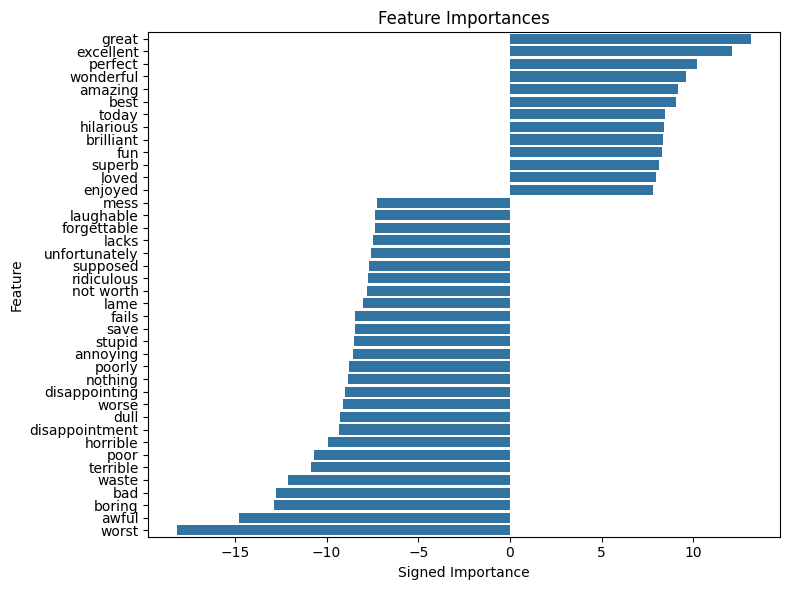

In [11]:
# Interpret the model's fit
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=[x[0] for x in sorted_biggest], y=[x[1] for x in sorted_biggest], ax=ax)
ax.set_title('Feature Importances')
ax.set_xlabel('Signed Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('logistic_importance.png')

plt.show()

In [12]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test,y_pred)
print(f"Test set accuracy: {test_acc}")

Test set accuracy: 0.9157


## Export model and vocabulary

We need to pickle the model and vocabulary in order to deploy the model

In [13]:
# pickle the vectorizer and inference model


with open('vocabulary.pkl', 'wb') as f_v :
    pkl.dump(vectorizer, f_v)
with open('sentiment_inference_model.pkl', 'wb') as f_m :
    pkl.dump(best_model, f_m)


In [14]:
# check that the vocabulary and inference model work when de-pickled

with open('vocabulary.pkl', 'rb') as f_v :
    loaded_vocab = pkl.load(f_v)
with open('sentiment_inference_model.pkl', 'rb') as f_m :
    loaded_model = pkl.load(f_m)

In [15]:
input_str = """
This was clearly no Tarantino film, but it had a lot of good things going for it. 
I liked the plot, and the visuals were above par. Not bad! Looking forward to more from this director! Not great.
"""

# input_str = """
# Not great. Not terrible
# """

transformed_input = loaded_vocab.transform([input_str])
input_sentiment = loaded_model.predict_proba(transformed_input)[0,1]
print(input_sentiment)

0.31964655664604746


In [16]:
for n, word in enumerate(input_str.split()):
    word_as_sparse_arr = vectorizer.transform([word])
    _, word_index_as_list = word_as_sparse_arr.nonzero()
    if word_index_as_list.size > 0 :
        strength = best_model.coef_[0, word_index_as_list[0]]
        print(f"{word} -- {strength:.2f}")

for n, (word1, word2) in enumerate(zip(input_str.split()[:-1],input_str.split()[1:])):
    bigram_as_sparse_arr = vectorizer.transform([f"{word1} {word2}"])
    _, bigram_index_as_list = bigram_as_sparse_arr.nonzero()

    if bigram_index_as_list.size > 0 :
        idx = bigram_index_as_list[0]
        bigram_string = ordered_keys[idx]
        if len(bigram_string.split()) > 0 :
            strength = best_model.coef_[0, bigram_index_as_list[0]]
            print(f"{word1} {word2} -- {strength:.2f}")


clearly -- -0.68
no -- -5.92
Tarantino -- -0.93
film, -- 1.45
had -- -1.49
lot -- 3.01
good -- 4.47
things -- 1.56
going -- 0.15
liked -- 5.42
plot, -- -3.23
visuals -- 0.99
above -- 1.68
par. -- -2.36
Not -- -3.33
bad! -- -12.74
Looking -- -2.11
forward -- -2.87
more -- 2.24
from -- -0.16
director! -- -4.32
Not -- -3.33
great. -- 13.16
was clearly -- -0.68
clearly no -- -5.92
no Tarantino -- -0.93
Tarantino film, -- -0.93
film, but -- 1.45
it had -- -1.49
had a -- -1.49
a lot -- 3.01
lot of -- 3.01
of good -- 4.47
good things -- 1.56
things going -- 0.29
going for -- 0.15
I liked -- 5.42
liked the -- 5.42
the plot, -- -3.23
plot, and -- -3.23
the visuals -- 0.99
visuals were -- 0.99
were above -- 1.68
above par. -- -2.36
par. Not -- -2.36
Not bad! -- 3.96
bad! Looking -- -2.11
Looking forward -- -3.04
forward to -- -2.87
to more -- 2.24
more from -- -1.45
from this -- -0.16
this director! -- -4.32
director! Not -- -3.33
Not great. -- -1.36


In [61]:
from asizeof import asizeof as better_sizeof
from sklearn.feature_extraction.text import CountVectorizer

# print(better_sizeof(vectorizer)/1e6)

small_vectorizer =  CountVectorizer(ngram_range=(1,2), stop_words = tokens_to_exclude, max_features=500, strip_accents='ascii' ).fit(reviews)

print(better_sizeof(small_vectorizer)/1e6)


509.055496


In [26]:
print(better_sizeof(ordered_keys)/1e6)


0.090096


## Conclusion

I've built a bag-of-words model with 1- and 2-grams, which achieves a 91% accuracy on the test set. The model is ready to deploy to production.